<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/Bayes-by-Backprop/notebooks/Gaussian_variational_posterior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install scipy==1.1.0 -q

In [0]:
from autograd import grad
from autograd.misc import flatten
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.scipy.stats.norm as norm
import pandas as pd


sns.set_style('white')
π = np.pi

$$ \mathcal{D}=\left\{x,y\right\}=\left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^N$$
$$ x,y \in \mathbb{R}^N $$

$$y = x + 0.3 \sin(2\pi(x + \epsilon)) + 0.3 sin(4\pi(x + \epsilon)) + \epsilon$$

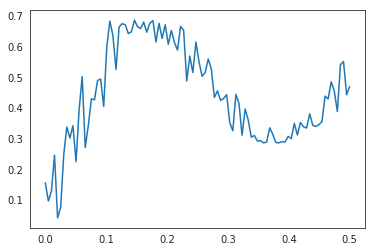

In [177]:
def make_data():
    x = np.linspace(0, 0.5, 100)
    ϵ = 0.02*np.random.randn(x.shape[0])
    y = x + 0.3*np.sin(2*π*(x + ϵ)) + 0.3*np.sin(4*π*(x + ϵ)) + ϵ
    return x,y

x, y = make_data()
plt.plot(x,y);

$$h = \sigma(W_1x + b_1)$$
$$\hat{y} = W_2h + b_2 $$

In [0]:
def relu(z):
    return z*(z > 0)

def init_params(input_size, 
                hidden_layer_size,
                output_size,
                scale=1,
                seed=None):
    rs = np.random.RandomState(seed)
    
    W1 = scale*rs.randn(hidden_layer_size, input_size)
    b1 = scale*rs.randn(hidden_layer_size)
    
    W2 = scale*rs.randn(output_size, hidden_layer_size)
    b2 = scale*rs.randn(output_size)
    return W1, b1, W2, b2
    

def l2_regularization(params, λ):
    params_flat, _ = flatten(params)
    return λ*np.dot(params_flat, params_flat)

def neural_net_predict(params, x):
    """Implements a shallow neural network for regression.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns regression results."""
    W1, b1, W2, b2 = params
    h = relu(np.dot(W1, x) + b1)
    y_pred = relu(np.dot(W2, h) + b2)
    return y_pred


def logprob(weights, inputs, targets, noise_scale=0.1):
    predictions = nn_predict(weights, inputs)
    return np.sum(norm.logpdf(predictions, targets, noise_scale))

def log_likelihood(params, x: np.array, y: np.array, σ: float=0.1) -> float:
    μ = neural_net_predict(params, x)
    return norm.logpdf(μ, y, σ).sum()

def loss(params, x: np.array, y: np.array) -> float:
    return -log_likelihood(params, x, y)

# Tests

In [0]:
# test neural_net_predict
W1, b1, W2, b2 = (np.eye(3), np.zeros(3),
                  np.eye(3), np.zeros(3))
params = (W1, b1, W2, b2)

x = np.array([-1, 0, 1])
y = np.array([0, 0, 1])
assert np.isclose(neural_net_predict(params, x), y).all()

# test log_likelihood
σ = 1/np.sqrt(2*π)
assert log_likelihood(params, x, y, σ) == 0

# Learning

In [181]:
x, y = make_data()
input_size = x.shape[0]
hidden_layer_size = 500
output_size = y.shape[0]
lr = 0.01

# compute gradient
loss_grad = grad(loss)

# init params
params = init_params(input_size, hidden_layer_size, 
                     output_size, scale=0.1, seed=0)

# Gradient Descent
losses = list()
for i in range(10_000):
    Δparams  = loss_grad(params, x, y)   
    params = [p - Δp*lr for p, Δp in zip(params, Δparams)]
    
    losses.append(loss(params, x, y))
print(i, losses[-1])

y_pred = neural_net_predict(params, x)

9999 843.6694830198524


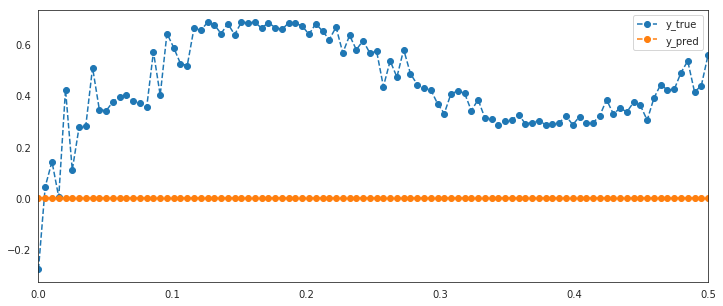

In [179]:
plot_option = dict(
    style='o--', 
    figsize=(12,5)
)

pd.DataFrame({
    'y_true': y,
    'y_pred': y_pred
}, index=x).plot(**plot_option);

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


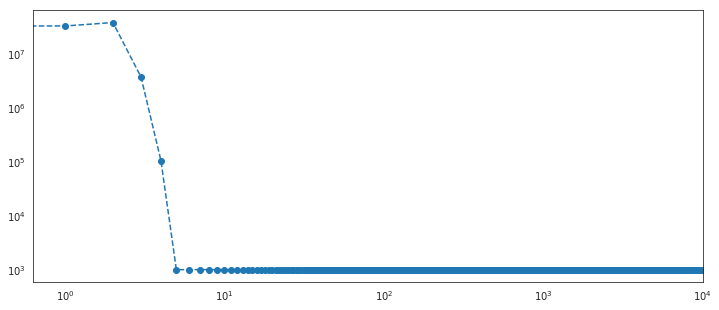

In [180]:
pd.Series(losses).plot(**plot_option, logy=True, logx=True);